# Post-Process 3D Clouds Input


There are many cases were you may want to post-process components from a 3D GCM output. Post-processing is used to compensate for simplicities, or assumptions within a GCM. For example, you may want to post-process clouds on your output spectra, even if your initial GCM run did not include the effects of clouds.

In this notebook you will learn:
1. How to post- process clouds using simple box model
2. How to post- process clouds using `virga`


You should already know:
1. How to format and regrid an `xarray` dataset

Next notebook you will learn:
1. How to create spectra and phase curves from 3D input

In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr

from picaso import justdoit as jdi
from picaso import justplotit as jpi

In [2]:
gcm_out =  jdi.HJ_pt_3d(as_xarray=True)

## Post-Process Clouds: User Options

1. User-defined input: this would only be used to explore simplistic cases (e.g. 100% H2O, or 50/50 H2/H2O). It also might be the case that you have abundance models from elsewhere (e.g. 3D model or GCM) and want to add it to your pressure/temperature `xarray`

2. Computationally intensive route: Usually GCM output is at a very high spatial resolution -- higher than what is needed to post-process spectra. If you want, you can grab chemistry for every single `lat` x `lon` point in your grid first. Then, regrid after.
    - Pro: you would only have to run it once, then you could regrid to different spatial resolutions later.
    - Con: computationally expensive (e.g. 128 x 64 pts x ~1 second = 2 hours per model .. though the exact time depends on how many altitude points you have)
3. Computationally efficient route: Regrid first, then compute chemistry.
    - Pro: would save potentially hundreds of chemistry computations
    - Con: if you aren't happy with your initial binning choice, you may have to repeat the calculation a few times to get it right


In this demo, we will do option #1 and #3 so that it can be self-contained and computationally fast, but you should explore what works best for your problem.


## Post-Process Clouds: User Defined Input

Very similar to chemistry process, we can create an xarray that has our cloud output. Note that for clouds there is a fourth dimension (wavelength)

In [3]:
# create coords
lon = gcm_out.coords.get('lon').values
lat = gcm_out.coords.get('lat').values
pres = gcm_out.coords.get('pressure').values
wno_grid = np.linspace(1e4/2,1e4/1,10)#cloud properties are defined on a wavenumber grid

#create box-band cloud model
fake_opd = np.zeros((len(lon), len(lat),len(pres), len(wno_grid))) # create fake data
where_lat = np.where(((lat>-50) & (lat<50)))#creating a grey cloud band
where_pres = np.where(((pres<0.01) & (pres>.001)))#creating a grey cloud band
for il in where_lat[0]:
    for ip in where_pres[0]:
        fake_opd[:,il,ip,:]=10 #optical depth of 10 (>>1)

#make up asymmetry and single scattering properties
fake_asymmetry_g0 = 0.8+ np.zeros((len(lon), len(lat),len(pres), len(wno_grid)))
fake_ssa_w0 = 0.9+ np.zeros((len(lon), len(lat),len(pres), len(wno_grid)))

# put data into a dataset
ds_cld= xr.Dataset(
    data_vars=dict(
        opd=(["lon", "lat","pressure","wno"], fake_opd,{'units': 'depth per layer'}),
        g0=(["lon", "lat","pressure","wno"], fake_asymmetry_g0,{'units': 'none'}),
        w0=(["lon", "lat","pressure","wno"], fake_ssa_w0,{'units': 'none'}),
    ),
    coords=dict(
        lon=(["lon"], lon,{'units': 'degrees'}),#required
        lat=(["lat"], lat,{'units': 'degrees'}),#required
        pressure=(["pressure"], pres,{'units': 'bar'}),#required
        wno=(["wno"], wno_grid,{'units': 'cm^(-1)'})#required for clouds
    ),
    attrs=dict(description="coords with vectors"),
)

### Visualize Cloud Input

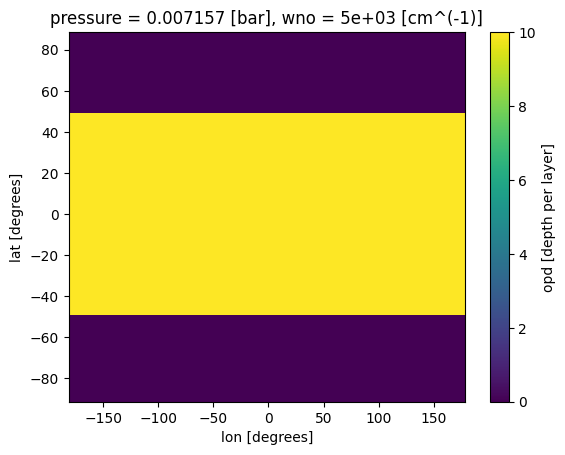

In [4]:
ds_cld['opd'].isel(pressure=where_pres[0][0],wno=0).plot(x='lon',y='lat')

### Add clouds to `picaso` bundle

As a recap, in the steps below we:
1. Initiate a new run  (jdi.inputs)
2. Define the geometry of the run  (phase_angle)
3. Set the pressure-temperature-lat-lon profile (atmosphere_3d)

Note here we are not worrying about chemical abundances (see post process chem tutorial). We will combine both clouds and chemistry steps in the next tutorial on 3D Spectra.

In [5]:
#first step is identical to what's been done in the past
case_3d = jdi.inputs()
case_3d.phase_angle(0, num_tangle=4, num_gangle=4)
#turning off alerts since we already went through this
case_3d.atmosphere_3d(gcm_out, regrid=True, plot=False,verbose=False)

/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Now we can add cloud box model, which will be automatically regridded to the inputs based on the `phase_angle` function ran above

verbose=True;regrid=True; Regridding 3D output to ngangle=4, ntangle=4, with phase=0.


/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


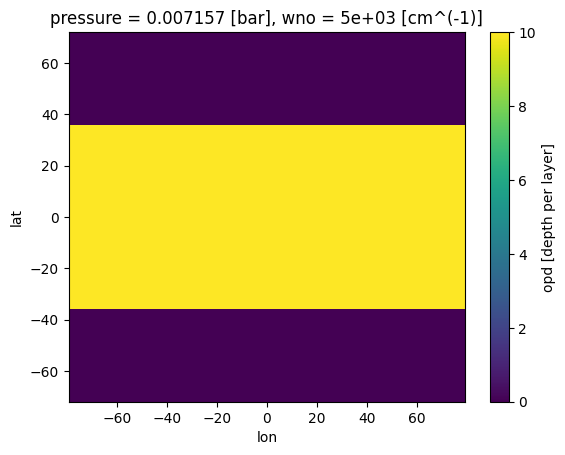

In [6]:
case_3d.clouds_3d(ds_cld,iz_plot=where_pres[0][0])

Stylize plots to see reversed pressure axis in log

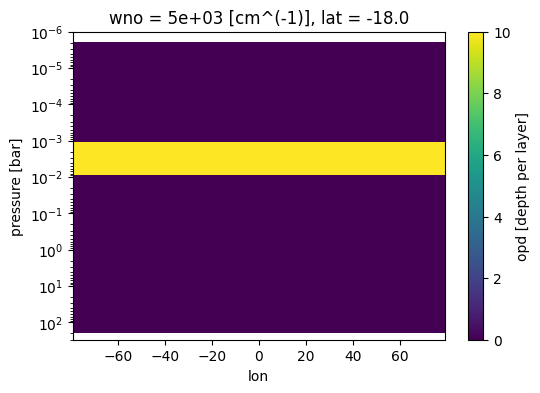

In [7]:
fig, ax = jpi.plt.subplots(figsize=(6, 4))
case_3d.inputs['clouds']['profile']['opd'].isel(
    lat=2,wno=0).plot(
    x='lon',y='pressure',ax=ax)
ax.set_ylim([3e2,1e-6])
ax.set_yscale('log')

### See other regridded variables

All the elements of your data bundle have been regridded! Though for now this is not too interesting since we have set the asymmetry to a constant value of 0.8

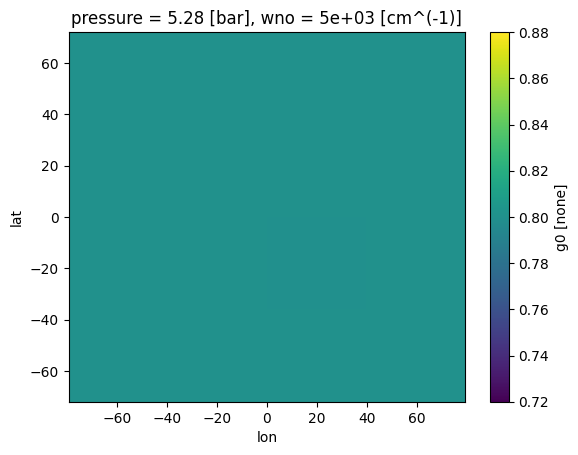

In [8]:
case_3d.inputs['clouds']['profile']['g0'].isel(pressure=10,wno=0).plot(
    x='lon',y='lat')

## Post-Process Clouds: `virga` cloud model

We will run this example on a very coarse (5x5) grid to make it faster. Note that similar to the `chemeq_3d` routine, running `virga_3d` will just run `ngangle`x`ntangle` 1d models. **There is no transport of particles in the vertical/horizontal direction.**


**NOTE!!** If you are not familiar with `virga` models it is highly recommended that you start in one-dimension first. [You can review the tutorials here](https://natashabatalha.github.io/virga/notebooks/1_GettingStarted.html). This tutorial will not explain the required `virga` inputs.

verbose=True;regrid=True; Regridding 3D output to ngangle=10, ntangle=10, with phase=0.


/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


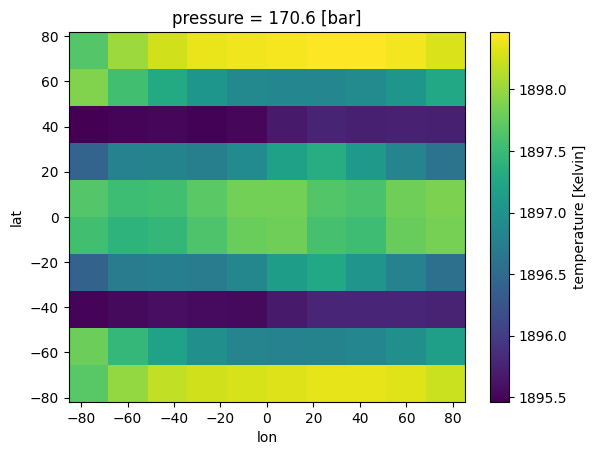

In [9]:
opacity = jdi.opannection(wave_range=[1,2])
gcm_out =  jdi.HJ_pt_3d(as_xarray=True,add_kz=True)
case_3d = jdi.inputs()
case_3d.phase_angle(0, num_tangle=10, num_gangle=10)
case_3d.atmosphere_3d(gcm_out, regrid=True)
case_3d.gravity(radius=1,radius_unit=jdi.u.Unit('R_jup'),
                mass=1, mass_unit=jdi.u.Unit('M_jup')) #any astropy units available
case_3d.star(opacity,5000,0,4.0, radius=1, radius_unit=jdi.u.Unit('R_sun'))

Run Virga!

In [10]:
# mieff_directory = '/data/virga/'
mieff_directory = os.path.join(os.getenv('picaso_refdata'),'virga')
clds = case_3d.virga_3d(['MnS'], mieff_directory,fsed=1,kz_min=1e10,
                        verbose=False,n_cpu=3, full_output=True
                       )

Plot optical depth as a function of longitude


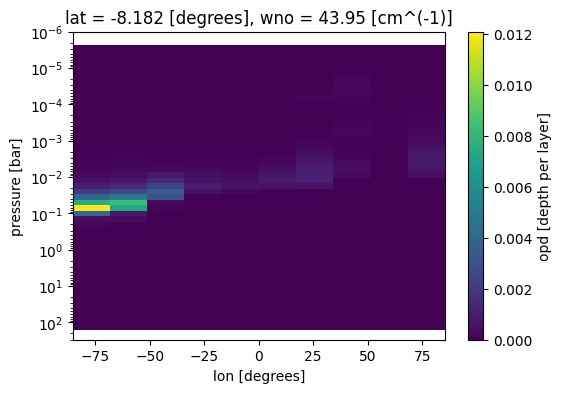

In [11]:
fig, ax = jpi.plt.subplots(figsize=(6, 4))
case_3d.inputs['clouds']['profile']['opd'].isel(lat=5,wno=0).plot(
    x='lon',y='pressure',ax=ax)
ax.set_ylim([3e2,1e-6])
ax.set_yscale('log')

### Trouble Shooting Negative Kz Values (smooth_kz)

GCM runs produce both positive and negative K_z values. A negative K_z represents downdrafts, which cannot be accounted for in `virga`. In fact, `virga` has a default minimum value of 1e5 cm$^2$/s. For the above run, note I used a very large kz_min value of 1e10cm$^2$/s. The smaller the k_z value, the  values create small particles. Let's take at some of the difficulty with smoothing over K_z profiles:

In [12]:
gcm_out =  jdi.HJ_pt_3d(as_xarray=True,add_kz=True)
test = jdi.inputs()
test.phase_angle(0, num_tangle=10, num_gangle=10)
test.atmosphere_3d(gcm_out, regrid=True, verbose=False, plot=False)

/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Explore some profiles in our 3d Kz grid

In [13]:
jpi.output_notebook()
df = test.inputs['atmosphere']['profile'].isel(lon=0, lat=0
                            ).to_pandas(
                            ).reset_index(
                            ).drop(
                            ['lat','lon'],axis=1
                            ).sort_values('pressure')

fig = jpi.figure(y_axis_type='log',y_range=[1e2,1e-6],x_axis_label='Kz (cm2/s)',
                 y_axis_label='pressure (bars)',
                 width=300, height=300, x_range=[-1e11, 1e11])
fig.line(df['kz']*1e4,df['pressure'])
jpi.show(fig)

Loading BokehJS ...

Experiment with splines

In [14]:
x=np.log10(df['pressure'].values)
df['logp']=x
y = np.log10(df['kz'].values)
x=x[y>0]
y = y[y>0]
spl = jdi.UnivariateSpline(x, y,ext=3)
df['splKz'] = spl(np.log10(df['pressure'].values))

/tmp/ipykernel_3638136/3022888736.py:3: RuntimeWarning: invalid value encountered in log10
  y = np.log10(df['kz'].values)


In [15]:
fig = jpi.figure(y_axis_type='log',y_range=[1e2,1e-6], x_axis_type='log',
                 x_axis_label='Kz (cm2/s)',
                 y_axis_label='pressure (bars)',
                 width=300, height=300, x_range=[1e5, 1e11])
fig.line(df['kz']*1e4,df['pressure'])
fig.line(10**df['splKz']*1e4, df['pressure'],color='red')
fig.scatter(10**y*1e4, 10**x,color='red',size=7)
jpi.show(fig)